# Universidad del Valle de Guatemala
## Security Data Science - 10
* Walter Danilo Saldaña Salguero - 19897
* Javier Alejandro Cotto Argueta - 19324

## Laboratorio 7: Ataques a Modelos de DL

Importamos librearias

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

C:\Users\Javier Cotto\AppData\Local\Programs\Python\Python310\lib\site-packages\art\estimators\certification\__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


Modelo

In [2]:
classy_101_model = tf.keras.models.load_model("Img_Class")

Cargamos los datos

In [3]:
X_train = np.load('X_train.npy') 
x_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

## Ataque de Evasión

Declaramos un clasificador

In [4]:
clasificador = KerasClassifier(
    model=classy_101_model)

Utilizamos gradiente descendiente

In [5]:
attack_fgsm = FastGradientMethod(
    estimator=clasificador, 
    eps=0.3
    )

Dataset a perturbar

In [6]:
X_test = x_test/255
test_images_adv = attack_fgsm.generate(x=X_test)

C:\Users\Javier Cotto\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


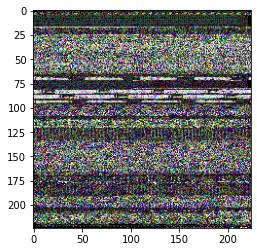

In [7]:
#Muestra de la imagen
plt.imshow(X=test_images_adv[0])

Evaluación del modelo con imagenes limpias y perturbadas

In [8]:
# Evaluating the model on clean images
score_clean = classy_101_model.evaluate(
    x=X_test, 
    y=y_test
    )

# Evaluating the model on adversarial images
score_adv = classy_101_model.evaluate(
    x=test_images_adv, 
    y=y_test
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

C:\Users\Javier Cotto\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Clean test set loss: 3.11 vs adversarial set test loss: 3.20
Clean test set accuracy: 0.21 vs adversarial test set accuracy: 0.08


### Medimos precisión con diferentes valores de epsilon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

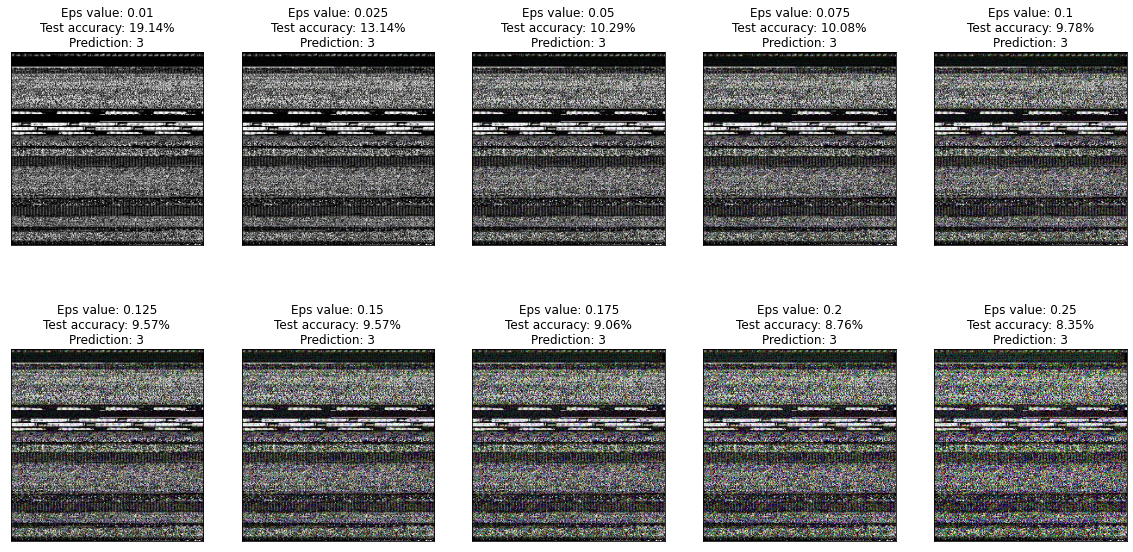

In [11]:
# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object for the current value of eps    
        attack_fgsm = FastGradientMethod(
            estimator=clasificador, 
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=X_test)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0])

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = clasificador._model.evaluate(
            x=test_images_adv, 
            y=y_test
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(classy_101_model.predict(
            x=np.expand_dims(a=test_images_adv[0], 
            axis=0)
            ))    

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()

## Ataque de Envenenamiento

Importamos las librearias

In [ ]:
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import to_categorical

# Defining a poisoning backdoor attack
backdoor = PoisoningAttackBackdoor(perturbation=add_pattern_bd)#Agrega un patron en los pixeles

# Defining a target label for poisoning
target = to_categorical(
    labels=np.repeat(a=5, repeats=5), 
    nb_classes=10
    )

# Inspecting the target labels
print(f"The target labels for poisoning are\n {target}")

In [ ]:
#Poisoning sample data
poisoned_images, poisoned_labels = backdoor.poison(
    x=x_train[:5], 
    y=target
    )

In [ ]:
# Creating a figure and axes for the poisoned images
fig, axes = plt.subplots(
    nrows=1, 
    ncols=5, 
    squeeze=True, 
    figsize=(15, 5)
    )

# Plotting the poisoned images
for i in range(len(poisoned_images)):
    axes[i].imshow(X=poisoned_images[i])
    axes[i].set_title(label=f"Label: {np.argmax(poisoned_labels[i])}")
    axes[i].set_xticks(ticks=[])
    axes[i].set_yticks(ticks=[])    

# Showing the plot
plt.show()

In [ ]:
# Defining a target label for poisoning
target = to_categorical(
    labels=[9], 
    nb_classes=10
    )[0]

# Defining a clean label backdoor attack
#Este tipo de ataque no modifica las etiquetas originales, por eso se llama "clean"
#Se combinaran ambos tipos de ataques

attack = PoisoningAttackCleanLabelBackdoor(
    backdoor=backdoor, 
    proxy_classifier=clasificador,#Clasificador usado para entrenar
    target=target, 
    pp_poison=0.75, #Porcentaje de imagenes a perturbar
    norm=2, 
    eps=5, 
    eps_step=0.1, 
    max_iter=200)

In [ ]:
# Poisoning training data
poisoned_images, poisoned_labels = attack.poison(
    x=x_train[:4904], 
    y=y_train[:4904]
    )

In [ ]:
# Function for creating victim model
def create_victim_model():
    # Defining the model's architecture
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(filters=32, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=10, activation="softmax")
    ])
    
    # Compiling the model
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
        )

    # Returning the model
    return model 

In [ ]:
model_poisoned = create_victim_model()
model_poisoned.fit(
    x=poisoned_images, 
    y=poisoned_labels, 
    epochs=1
    )

In [ ]:
# Evaluating the poisoned classifier on clean test data
scores_clean = model_poisoned.evaluate(
    x=test_images, 
    y=test_labels
    )

# Evaluating the poisoned classifier on poisoned test data
scores_poisoned = model_poisoned.evaluate(
    x=px_test, 
    y=py_test
    )

# Comparing test losses
print(f"Clean test loss: {scores_clean[0]:.2f} " 
      f"vs poisoned test loss: {scores_poisoned[0]:.2f}")

# Comparing test accuracies
print(f"Clean test accuracy: {scores_clean[1]:.2f} " 
      f"vs poisoned test accuracy: {scores_poisoned[1]:.2f}")

In [ ]:
# Setting the number of rows and columns for the plot
nrows, ncols = 2, 5

# Creating a figure and axes
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(25, 10)
    )

# Getting predictions for the first ten poisoned images
poisoned_predictions = model_poisoned.predict(x=px_test[:10])

# Defining a counting variable
counter = 0

# Iterating over rows and cols,
# plotting poisoned images
# along with their predictions
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(px_test[counter])
        axes[i, j].set_title(label=f"Prediction: {np.argmax(poisoned_predictions[counter])}")
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Incrementing the counter
        counter += 1